In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from ewstools import core
import itertools

In [2]:
# set your path
path_from = "/Users/liqingchun/Google Drive/Dissertation/Paper/Journal/Early Warning/Evelyn_results/Covid-Early-Warning/Filtered-Time-Series-Data/Austin/"
path_written_to = "/Users/liqingchun/Google Drive/Dissertation/Paper/Journal/Early Warning/Evelyn_results/Covid-Early-Warning/results/Austin/"

In [3]:
cityname = "Austin"

In [181]:
input_jan = "austin-time-series-Jan-new.csv"
input_feb = "austin-time-series-Feb-new.csv"
input_mar = "austin-time-series-Mar-new.csv"

In [182]:
# first case, death, shelter in place

first_case = "Mar. 13th"
first_death = "Mar. 27th"
shelter = "Mar. 24th"

# start from zero, since the graph has zero
case_num = 31 + 29 + 13 - 1
death_num = 31 + 29 + 27 - 1
shelter_num = 31 + 29 + 24 - 1

In [183]:
# set the starting value, ending value and step for bandwidth and rowing window
bw_start = 20
bw_end = 90
bw_step = 2
bw_number = 36

rw_start = 0.2
rw_end = 0.5
rw_step = 0.01
rw_number = 31


# move forward
span = 0.25
lags = [1] 
ews = ['sd','ac'] 

In [184]:
os.chdir(path_from)
os.getcwd()

'/Users/liqingchun/Google Drive/Dissertation/Paper/Journal/Early Warning/Evelyn_results/Covid-Early-Warning/Filtered-Time-Series-Data/Austin'

In [185]:
# read
df1 = pd.read_csv(input_jan)
print(df1.columns)

Index(['Unnamed: 0', 'Date', 'Essential', 'NonEssential'], dtype='object')


In [186]:
# drop the index column
df1 = df1.drop('Unnamed: 0',axis=1)

In [187]:
# schema of the data frame
df2

,Date,Essential,NonEssential
0,2020-02-01,24827,162270
1,2020-02-02,20042,107166
2,2020-02-03,22959,132334
3,2020-02-04,21333,127673
4,2020-02-05,22237,122772
5,2020-02-06,21287,129389
6,2020-02-07,25434,148433
7,2020-02-08,23550,153259
8,2020-02-09,20656,108335
9,2020-02-10,24134,125656


In [188]:
df2 = pd.read_csv(input_feb)
df2 = df2.drop('Unnamed: 0',axis=1)
df3 = pd.read_csv(input_mar)
df3 = df3.drop('Unnamed: 0',axis=1)
print(df2.shape)
print(df3.shape)

(29, 3)
(31, 3)


In [189]:
# combine
cityWhole = pd.concat([df1,df2,df3],ignore_index=True)
cityWhole

,Date,Essential,NonEssential
0,2020-01-01,20110,93270
1,2020-01-02,31068,125011
2,2020-01-03,32111,139191
3,2020-01-04,26188,133131
4,2020-01-05,23814,106879
...,...,...,...
86,2020-03-27,13906,42458
87,2020-03-28,12228,38110
88,2020-03-29,17730,84765
89,2020-03-30,13609,40142


In [301]:
baseline = cityWhole.loc[16:36,:].set_index('Date').loc[:,'Essential':'NonEssential']
temp_avr = baseline.values.reshape(-1,7,2).mean(axis=1)

temp_avr = temp_avr.mean(axis=0)

#temp_avr

perc_change = cityWhole.loc[37:85,:].set_index('Date').loc[:,'Essential':'NonEssential']
perc_change_mean = perc_change.values.reshape(-1,7,2).mean(axis=1)

#perc_change_mean

temp_result = (temp_avr - perc_change_mean)/temp_avr

#temp_result

print(temp_result[3])
print(temp_result[-1])

[0.17847234 0.10203402]
[0.53115244 0.66260145]


In [191]:
total_days = len(cityWhole)
print(total_days)
cityWhole.index

91


RangeIndex(start=0, stop=91, step=1)

In [192]:
# create two list of possible rowing-window values and band-width values, put them into list to feed into itertools functions
rw = list(np.linspace(rw_start,rw_end,rw_number, endpoint=True))
bw = list(np.linspace(bw_start,bw_end,bw_number, endpoint=True))
list1 = [rw,bw]

In [193]:
bw

[20.0,
 22.0,
 24.0,
 26.0,
 28.0,
 30.0,
 32.0,
 34.0,
 36.0,
 38.0,
 40.0,
 42.0,
 44.0,
 46.0,
 48.0,
 50.0,
 52.0,
 54.0,
 56.0,
 58.0,
 60.0,
 62.0,
 64.0,
 66.0,
 68.0,
 70.0,
 72.0,
 74.0,
 76.0,
 78.0,
 80.0,
 82.0,
 84.0,
 86.0,
 88.0,
 90.0]

In [194]:
# generate a list of tuples that contains (rowing-window-value,bandwidth-value) pairs
prod = itertools.product(*list1)
TupList = []
for i in prod:
    TupList.append(i)

In [195]:
TupList[0]

(0.2, 20.0)

In [196]:
# create 2 new lists to store all values of std and all values of lag-1AC
storage_std = np.array([])
storage_lag = np.array([])

In [197]:
# for each (rowing-window,bandwidth) pair, compute the ews dataframe, store the corresponding kendall tau value of std into storage_std, and store the corresponding kendall tau value of lag into storage_lag
for i in range(len(TupList)):
    ews_dic = core.ews_compute(cityWhole["Essential"], roll_window = TupList[i][0],smooth ='Gaussian',band_width= TupList[i][1],span = span,lag_times = [1], ews = ews,upto = 'Full')
    if i != 0: # exclude the first item since they are NoneType objects and this will make the entire array to be type "object" if include them
        storage_std = np.append(storage_std,ews_dic['Kendall tau']["Standard deviation"][0]) # pandas series with 1 element, so index 0
        storage_lag = np.append(storage_lag, ews_dic['Kendall tau']["Lag-1 AC"][0]) # pandas series with 1 element, so index 0

In [198]:
# print out the max kendall tau for std and lagAC for comparison
max_std = np.amax(storage_std)
max_lag = np.amax(storage_lag)
print(max_std)
print(max_lag)

0.7187789084181315
0.7983348751156337


In [199]:
print(len(TupList))
print(len(storage_std))
print(len(storage_lag))

1116
1115
1115


##### Add one when locating the tuple in TupList since the first item is "None Type" in tupList and we did not store that in storage_std and storage_lag

In [200]:
# find the location/index of maximum std in the storage_std, and use the index to find the corresponding rowing-window and bandwidth
print("*** max std located in pair ***")
max_std_index = np.where(storage_std == max_std)
print("index at : " + str(max_std_index[0]+1) + "in TupList")
# store the tuple for comparison
target_pair_std = TupList[max_std_index[0][0]+1]
print("tuple (rowing-windows,bandwidth): " + str(target_pair_std))
print("largest std kendall tau: " + str(max_std))

*** max std located in pair ***
index at : [1110 1111 1112 1113 1114 1115]in TupList
tuple (rowing-windows,bandwidth): (0.5, 80.0)
largest std kendall tau: 0.7187789084181315


In [201]:
# some mechanism to find the index of maximum lagAC and the corresponding tuple
print("*** max lag located in pair ***")
max_lag_index = np.where(storage_lag == max_lag)
print("index at : " + str(max_lag_index[0]+1) + "in TupList")
# store the tuple for comparison
target_pair_lag = TupList[max_lag_index[0][0]+1]
print("tuple (rowing-windows,bandwidth): " + str(target_pair_lag))
print("largest lag kendall tau: " + str(max_lag))

*** max lag located in pair ***
index at : [1110 1111 1112 1113 1114 1115]in TupList
tuple (rowing-windows,bandwidth): (0.5, 80.0)
largest lag kendall tau: 0.7983348751156337


In [202]:
# create an empty tuple, the tuple that contains larger Kendall Tau value will be selected
# select either AC max tuple or Standard Deviation max tuple automatically
selected_pair = ()
if (max_lag > max_std):
    selected_pair = target_pair_lag
    print("lagAC larger, select " + str(target_pair_lag))
elif(max_lag < max_std):
    selected_pair = target_pair_std
    print("std larger, select " + str(target_pair_std))
else:
    print("rare case!")
    selected_pair = target_pair_std

lagAC larger, select (0.5, 80.0)


In [203]:
# double check, print out
#setRW = selected_pair[0]
#setBW = selected_pair[1]
setRW = target_pair_std[0]
setBW = target_pair_std[1]
print("setRW : " + str(setRW))
print("setBW : " + str(setBW))

ews_dic_std = core.ews_compute(cityWhole["Essential"], 
                          roll_window = setRW,
                           smooth ='Gaussian',
                           band_width= setBW,
                          span = span,
                          lag_times = [1], 
                          ews = ews,
                          upto = 'Full')

setRW : 0.5
setBW : 80.0


In [204]:
# double check, print out
#setRW = selected_pair[0]
#setBW = selected_pair[1]
setRW = target_pair_lag[0]
setBW = target_pair_lag[1]
print("setRW : " + str(setRW))
print("setBW : " + str(setBW))

ews_dic_lag = core.ews_compute(cityWhole["Essential"], 
                          roll_window = setRW,
                           smooth ='Gaussian',
                           band_width= setBW,
                          span = span,
                          lag_times = [1], 
                          ews = ews,
                          upto = 'Full')

setRW : 0.5
setBW : 80.0


In [205]:
# double check, print out
setRW = selected_pair[0]
setBW = selected_pair[1]
print("setRW : " + str(setRW))
print("setBW : " + str(setBW))

ews_dic = core.ews_compute(cityWhole["Essential"], 
                          roll_window = setRW,
                           smooth ='Gaussian',
                           band_width= setBW,
                          span = span,
                          lag_times = [1], 
                          ews = ews,
                          upto = 'Full')

setRW : 0.5
setBW : 80.0


In [206]:
# dfs
df_ews_std = ews_dic_std['EWS metrics']
df_ktau_std = ews_dic_std['Kendall tau']

df_ews_lag = ews_dic_lag['EWS metrics']
df_ktau_lag = ews_dic_lag['Kendall tau']

df_ews = ews_dic['EWS metrics']

In [207]:
# different cities needs adjustment of the location of annotation since total number varies
# set to mean, so location set automatically

# location of annotation for the 1st graph
annotation_location_1 = np.mean(df_ews[["State variable"]])
annotation_location_2 = np.mean(df_ews[["Residuals"]])
# location of annotations for the 2nd graph
annotation_location_3 = np.mean(df_ews_std["Standard deviation"])
# location of annotations for the 3rd graph
annotation_location_4 = np.mean(df_ews_lag["Lag-1 AC"])

In [208]:
# 2 parameter: you may want to change these two
LegendTF = False
generateNow = True

# set the early warning (gray)band using the variables below 

# Action Required: the start and the end of band in first graph
bar_start_1 = 53 # need modification
bar_end_1 = 55 # need modification


# Action Required: the start and the end of band in 2nd graph
bar_start_2 = 59 # need modification
bar_end_2 = 61 # need modification


# Action Required: the start and the end of band in 3rd graph
bar_start_3 = 53 # need modification
bar_end_3 = 55 # need modification

In [209]:
cityWhole.loc[53]

Date            2020-02-23
Essential            22980
NonEssential        107559
Name: 53, dtype: object

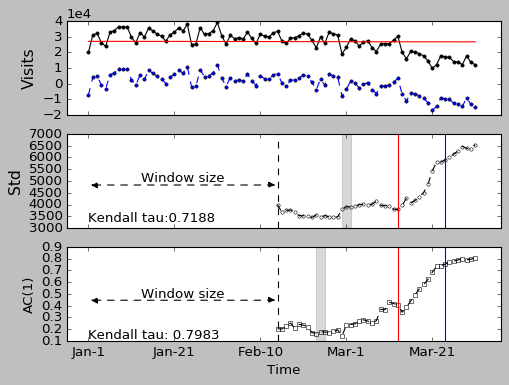

In [210]:
# the dates and string of first case, first death , shelter in place order are set at the beginning in the notebook
# parameter needs to be set are in the previous cell


# constant, you don't need to change them, but if you want to you can change ALPHA OR DIST 
ALPHA = 0.3
DIST = 5
ZERO = 0
NROWS = 3
NCOLS = 1
windown_position_std = int(target_pair_std[0]*total_days-1)
windown_position_lag = int(target_pair_lag[0]*total_days-1)
# title = ("Essential Early warning signals for city " + cityname)
# No action require below
plt.style.use('classic')
fig1, axes = plt.subplots(nrows = NROWS, ncols = NCOLS, figsize=(7,5), sharex=True)
df_ews[['State variable']].plot(ax=axes[0], 
        color='black', xlim = (-DIST,total_days + DIST),legend = LegendTF,
        marker='o', markersize=3) # frame auto set
df_ews[['Smoothing']].plot(ax=axes[0], color='red', xlim = (-DIST,total_days + DIST),legend = LegendTF)
df_ews[['Residuals']].plot(ax=axes[0], color='blue', xlim = (-DIST,total_days + DIST),legend = LegendTF,
                            marker='o', markersize=3, linestyle='dashed') # frame auto set
#axes[0].axvline(x = case_num, color='red', label='First case')
#axes[0].axvline(x = death_num, color='yellow')
#axes[0].axvline(x = shelter_num, color='yellow', label='Shelter in place')
#axes[0].annotate('First Case' +'\n'+ first_case, xy=((case_num + DIST), annotation_location_2)) # location auto set
#axes[0].annotate('First Death'+'\n'+ first_death, xy=((death_num - DIST), annotation_location_2)) # location auto set
#axes[0].annotate('Shelter in Place'+'\n'+ shelter, xy=((shelter_num + DIST), annotation_location_1)) # location auto set
#axes[0].axvspan(bar_start_1, bar_end_1, alpha=ALPHA, color='gray')
#axes[0].legend(loc=3, ncol=3)
axes[0].set_ylabel('Visits', fontsize=14)
axes[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#axes[0].annotate('(a)', xy=(1 - DIST, 0.8*np.max(df_ews[["State variable"]])))




df_ews_std['Standard deviation'].plot(ax=axes[1],legend=False, xlim = (-DIST,total_days+DIST),
                                      color="black", marker='o', markersize=3, ls='--', markerfacecolor='none') # frame auto set
axes[1].axvline(x = case_num, color='red')
#axes[1].axvline(x = death_num, color='purple')
axes[1].axvline(x = shelter_num, color='blue')
axes[1].annotate("Kendall tau:" + str(round(df_ktau_std["Standard deviation"][0],4)), xy=(ZERO, 0.75*annotation_location_3)) # location auto set
#axes[1].annotate('First Case' +'\n'+ first_case, xy=((case_num + DIST), annotation_location_3)) # location auto set
#axes[1].annotate('First Death'+'\n'+ first_death, xy=((death_num - DIST), annotation_location_3)) # location auto set
#axes[1].annotate('Shelter in Place'+'\n'+ shelter, xy=((shelter_num + DIST), annotation_location_3)) # location auto set
axes[1].axvspan(bar_start_2, bar_end_2, alpha = ALPHA, color='gray', label='Early Warning Period')
axes[1].axvline(x = windown_position_std, color='black', ls='--')
axes[1].annotate("", xy=(0, 1.1*annotation_location_3), xytext=(windown_position_std, 1.1*annotation_location_3),
    arrowprops=dict(arrowstyle="<|-|>", connectionstyle="arc3", ls='--',color='black'))
axes[1].text(windown_position_std*0.5, 1.1*annotation_location_3, 'Window size',
            {'color': 'black', 'ha': 'center', 'va': 'bottom'})
#axes[1].legend(loc=2, ncol=1)
axes[1].set_ylabel('Std', fontsize=14)
#axes[1].annotate('(b)', xy=(1 - DIST, 0.95*np.max(df_ews_std[["Standard deviation"]])))





df_ews_lag[['Lag-1 AC']].plot(ax=axes[2],legend=False, xlim = (-DIST,total_days+DIST),
                             color="black", marker='s', markersize=3, ls='--', markerfacecolor='none') # frame auto set
axes[2].axvline(x = case_num, color='red')
#axes[2].axvline(x = death_num, color='purple')
axes[2].axvline(x = shelter_num, color='blue')
axes[2].annotate("Kendall tau: " + str(round(df_ktau_lag["Lag-1 AC"][0],4)),xy=(ZERO, annotation_location_4*0.3)) # location auto set

#axes[2].annotate('First Case' +'\n'+ first_case, xy=((case_num + DIST), annotation_location_4)) # location auto set
#axes[2].annotate('First Death'+'\n'+ first_death, xy=((death_num - DIST), annotation_location_4)) # location auto set
#axes[2].annotate('Shelter in Place'+'\n'+ shelter, xy=((shelter_num + DIST), annotation_location_4)) # location auto set
axes[2].axvspan(bar_start_3, bar_end_3, alpha = ALPHA, color='gray', label='Early Warning Period') 
axes[2].axvline(x = windown_position_lag, color='black', ls='--')
axes[2].annotate("", xy=(0, 1.1*annotation_location_4), xytext=(windown_position_lag, 1.1*annotation_location_4),
    arrowprops=dict(arrowstyle="<|-|>", connectionstyle="arc3", ls='--', color='black'))
axes[2].text(windown_position_lag*0.5, 1.1*annotation_location_4, 'Window size',
            {'color': 'black', 'ha': 'center', 'va': 'bottom'})
#axes[2].legend(loc=2)
axes[2].set_ylabel('AC(1)')
#axes[2].annotate('(c)', xy=(1-DIST, 0.95*np.max(df_ews_lag[["Lag-1 AC"]])))
x_tick = [1, 'Jan-1', 'Jan-21', 'Feb-10', 'Mar-1', 'Mar-21']
axes[2].set_xticklabels(x_tick)


foo_fig = plt.gcf()

# set "generateNow" in previous cell
if (generateNow):
    os.chdir(path_written_to)
    foo_fig.savefig((cityname + "-Essential-new.png"))

In [211]:
np.max(df_ktau_lag[["Lag-1 AC"]])

Lag-1 AC    0.798335
dtype: float64

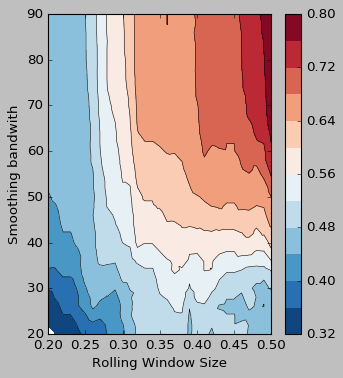

In [212]:
fig, ax = plt.subplots(figsize=(4.5,5))
#fig = plt.figure(figsize=(10,8))
plt.style.use('classic')

#z = list(storage_lag)
#z.insert(0, np.min(storage_lag))
#ax.contour(bw, rw, np.array(z).reshape(30, 38), cmap="RdBu_r")

window, bandwith = zip(*TupList)
x = window[1:]
y = bandwith[1:]
if np.max(storage_std)>np.max(storage_lag):
    z = storage_std
else:
    z= storage_lag
ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
cntr = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")
fig.colorbar(cntr, ax=ax)
ax.set(xlim=(0.2, 0.5), ylim=(20, 90))
ax.set_ylabel('Smoothing bandwith', fontsize=12)
ax.set_xlabel('Rolling Window Size', fontsize=12)

foo_fig = plt.gcf()  # 'get current figure'
# set "generateNow" in previous cell
if (generateNow):
    os.chdir(path_written_to)
    foo_fig.savefig((cityname + "-Essential_contour-new.png"))

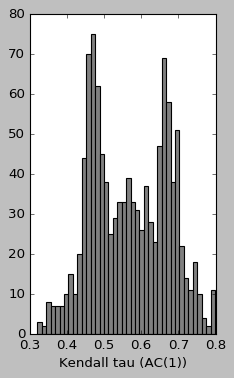

In [213]:
plt.style.use('classic')
fig = plt.figure(figsize=(3,5))

#z = list(storage_lag)
#z.insert(0, np.min(storage_lag))
#ax.contour(bw, rw, np.array(z).reshape(30, 38), cmap="RdBu_r")

if np.max(storage_std)>np.max(storage_lag):
    a = storage_std
    label = 'Std'
else:
    a= storage_lag
    label = 'AC(1)'

hist,bins = np.histogram(a,bins=40)

plt.hist(a, bins = bins, color='grey')

plt.xlabel('Kendall tau (' + label + ')')


foo_fig = plt.gcf()  # 'get current figure'
# set "generateNow" in previous cell
if (generateNow):
    os.chdir(path_written_to)
    foo_fig.savefig((cityname + "-Essential_histogram-new.png"))

## Here starts Non-essential

In [214]:
# reset storage
storage_std = np.array([])
storage_lag = np.array([])
print("should print out two empty brakets below")
print(storage_std)
print(storage_lag)

for i in range(len(TupList)):
    ews_dic = core.ews_compute(cityWhole["NonEssential"], roll_window = TupList[i][0],smooth ='Gaussian',band_width= TupList[i][1],span = span,lag_times = [1], ews = ews,upto = 'Full')
    if i != 0:
        storage_std = np.append( storage_std,ews_dic['Kendall tau']["Standard deviation"][0])
        storage_lag = np.append(storage_lag, ews_dic['Kendall tau']["Lag-1 AC"][0])

should print out two empty brakets below
[]
[]


### I know they can be overriden, but just in case we reset all variables

In [215]:
max_std = -100000000
max_lag = -100000000
max_std = np.amax(storage_std)
max_lag = np.amax(storage_lag)
print(max_std)
print(max_lag)

0.8724489795918365
0.8582202111613877


In [216]:
print(len(TupList))
print(len(storage_std))
print(len(storage_lag))

1116
1115
1115


PLUS 1 SINCE LENGTH IS DIFFERENT

In [217]:
# reset
max_std_index = -10000000
target_pair_std = (-10000000,-100000000)
# compute
print("*** max std located in pair ***")
max_std_index = np.where(storage_std == max_std) # find the largest element index
print("index at : " + str(max_std_index[0] + 1))
target_pair_std = TupList[max_std_index[0][0] + 1]
print("tuple (rowing-windows,bandwidth): " + str(target_pair_std))
print("largest std kendall tau: " + str(max_std))

*** max std located in pair ***
index at : [1008]
tuple (rowing-windows,bandwidth): (0.48000000000000004, 20.0)
largest std kendall tau: 0.8724489795918365


In [218]:
# reset
max_lag_index = -1000000000
target_pair_lag = (-1000000000,-1000000000)
# compute
print("*** max lag located in pair ***")
max_lag_index = np.where(storage_lag == max_lag)
print("index at : " + str(max_lag_index[0] + 1)) # set to the index zero when multiple results return because we try to have smaller rowing window
target_pair_lag = TupList[max_lag_index[0][0] + 1]
print("tuple (rowing-windows,bandwidth): " + str(target_pair_lag))
print("largest lag kendall tau: " + str(max_lag))

*** max lag located in pair ***
index at : [864 865 900 901]
tuple (rowing-windows,bandwidth): (0.44, 20.0)
largest lag kendall tau: 0.8582202111613877


In [219]:
selected_pair = ()
if (max_lag > max_std):
    selected_pair = target_pair_lag
    print("lagAC larger, select " + str(target_pair_lag))
elif(max_lag < max_std):
    selected_pair = target_pair_std
    print("std larger, select " + str(target_pair_std))
else:
    print("rare case!")
    selected_pair = target_pair_lag

std larger, select (0.48000000000000004, 20.0)


In [220]:
setRW = -10000000
setBW = -10000000
setRW = round(selected_pair[0],3)
setBW = selected_pair[1]
print("setRW : " + str(setRW))
print("setBW : " + str(setBW))

setRW : 0.48
setBW : 20.0


In [221]:
ews_dic = core.ews_compute(cityWhole["NonEssential"], 
                          roll_window = setRW,
                           smooth ='Gaussian',
                           band_width=setBW,
                          span = span,
                          lag_times = [1], 
                          ews = ews,
                          upto = 'Full')

In [222]:
setRW = target_pair_std[0]
setBW = target_pair_std[1]
print("setRW : " + str(setRW))
print("setBW : " + str(setBW))

ews_dic_std = core.ews_compute(cityWhole["NonEssential"], 
                          roll_window = setRW,
                           smooth ='Gaussian',
                           band_width= setBW,
                          span = span,
                          lag_times = [1], 
                          ews = ews,
                          upto = 'Full')

setRW : 0.48000000000000004
setBW : 20.0


In [223]:
setRW = target_pair_lag[0]
setBW = target_pair_lag[1]
print("setRW : " + str(setRW))
print("setBW : " + str(setBW))

ews_dic_lag = core.ews_compute(cityWhole["NonEssential"], 
                          roll_window = setRW,
                           smooth ='Gaussian',
                           band_width= setBW,
                          span = span,
                          lag_times = [1], 
                          ews = ews,
                          upto = 'Full')

setRW : 0.44
setBW : 20.0


In [224]:
# dfs
df_ews_std = ews_dic_std['EWS metrics']
df_ktau_std = ews_dic_std['Kendall tau']

df_ews_lag = ews_dic_lag['EWS metrics']
df_ktau_lag = ews_dic_lag['Kendall tau']

df_ews = ews_dic['EWS metrics']

In [225]:
df_ktau_std

,Lag-1 AC,Standard deviation
0,0.826531,0.872449


In [226]:
#  reset
annotation_location_1 = -10000000
annotation_location_2 = -10000000
annotation_location_3 = -10000000
annotation_location_4 = -10000000

# location of annotation for the 1st graph
annotation_location_1 = np.mean(df_ews[["State variable"]])
annotation_location_2 = np.mean(df_ews[["Residuals"]])
# location of annotations for the 2nd graph
annotation_location_3 = np.mean(df_ews_std["Standard deviation"])
# location of annotations for the 3rd graph
annotation_location_4 = np.mean(df_ews_lag["Lag-1 AC"])

In [227]:
# 2 parameter: you may want to change these two
LegendTF = False
generateNow = True

# set the early warning (gray)band using the variables below 

# Action Required: the start and the end of band in first graph
bar_start_1 = 72 # need modification
bar_end_1 = 74 # need modification


# Action Required: the start and the end of band in 2nd graph
bar_start_2 = 65 # need modification
bar_end_2 = 67 # need modification


# Action Required: the start and the end of band in 3rd graph
bar_start_3 = 61 # need modification
bar_end_3 = 63 # need modification

In [228]:
cityWhole.loc[61]

Date            2020-03-02
Essential            28540
NonEssential        117075
Name: 61, dtype: object

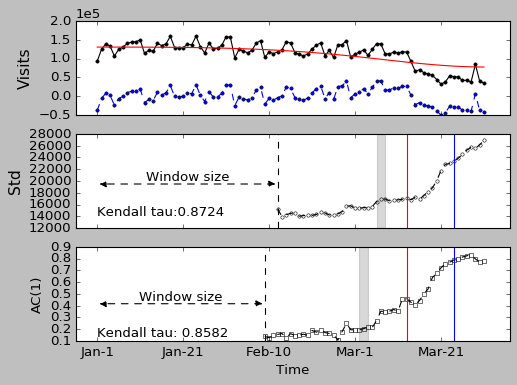

In [229]:
# the dates and string of first case, first death , shelter in place order are set at the beginning in the notebook
# parameter needs to be set are in the previous cell

# constants , you don't need to change them
ZERO = 0
DIST = 5
ALPHA = 0.7
NROWS = 3
NCOLS = 1
#x_tick = 5*[1] + ['Jan-1'] + 19*[1] + ['Jan-21'] + 19*[1] + ['Feb-10'] + 19*[1] + ['Mar-1'] + 19*[1] + ['Mar-21']
x_tick = [1, 'Jan-1', 'Jan-21', 'Feb-10', 'Mar-1', 'Mar-21']

# plots
# constant, you don't need to change them, but if you want to you can change ALPHA OR DIST 
ALPHA = 0.3
DIST = 5
ZERO = 0
NROWS = 3
NCOLS = 1
windown_position_std = int(target_pair_std[0]*total_days-1)
windown_position_lag = int(target_pair_lag[0]*total_days-1)
# title = ("Essential Early warning signals for city " + cityname)
# No action require below
fig1, axes = plt.subplots(nrows = NROWS, ncols = NCOLS, figsize=(7,5), sharex=True)
plt.style.use('classic')
df_ews[['State variable']].plot(ax=axes[0], 
        color='black', xlim = (-DIST,total_days + DIST),legend = LegendTF,
        marker='o', markersize=3) # frame auto set
df_ews[['Smoothing']].plot(ax=axes[0], color='red', xlim = (-DIST,total_days + DIST),legend = LegendTF)
df_ews[['Residuals']].plot(ax=axes[0], color='blue', xlim = (-DIST,total_days + DIST),legend = LegendTF,
                            marker='o', markersize=3, linestyle='dashed') # frame auto set
#axes[0].axvline(x = case_num, color='red', label='First case')
#axes[0].axvline(x = death_num, color='yellow')
#axes[0].axvline(x = shelter_num, color='yellow', label='Shelter in place')
#axes[0].annotate('First Case' +'\n'+ first_case, xy=((case_num + DIST), annotation_location_2)) # location auto set
#axes[0].annotate('First Death'+'\n'+ first_death, xy=((death_num - DIST), annotation_location_2)) # location auto set
#axes[0].annotate('Shelter in Place'+'\n'+ shelter, xy=((shelter_num + DIST), annotation_location_1)) # location auto set
#axes[0].axvspan(bar_start_1, bar_end_1, alpha=ALPHA, color='gray')
#axes[0].legend(loc=3, ncol=3)
axes[0].set_ylabel('Visits', fontsize=14)
axes[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#axes[0].annotate('(d)', xy=(1 - DIST, 0.8*np.max(df_ews[["State variable"]])))




df_ews_std['Standard deviation'].plot(ax=axes[1],legend=False, xlim = (-DIST,total_days+DIST),
                                      color="black", marker='o', markersize=3, ls='--', markerfacecolor='none') # frame auto set
axes[1].axvline(x = case_num, color='red')
#axes[1].axvline(x = death_num, color='purple')
axes[1].axvline(x = shelter_num, color='blue')
axes[1].annotate("Kendall tau:" + str(round(df_ktau_std["Standard deviation"][0],4)), xy=(ZERO, 0.8*annotation_location_3)) # location auto set
#axes[1].annotate('First Case' +'\n'+ first_case, xy=((case_num + DIST), annotation_location_3)) # location auto set
#axes[1].annotate('First Death'+'\n'+ first_death, xy=((death_num - DIST), annotation_location_3)) # location auto set
#axes[1].annotate('Shelter in Place'+'\n'+ shelter, xy=((shelter_num + DIST), annotation_location_3)) # location auto set
axes[1].axvspan(bar_start_2, bar_end_2, alpha = ALPHA, color='gray', label='Early Warning Period')
axes[1].axvline(x = windown_position_std, color='black', ls='--')
axes[1].annotate("", xy=(0, 1.1*annotation_location_3), xytext=(windown_position_std, 1.1*annotation_location_3),
    arrowprops=dict(arrowstyle="<|-|>", connectionstyle="arc3", ls='--',color='black'))
axes[1].text(windown_position_std*0.5, 1.1*annotation_location_3, 'Window size',
            {'color': 'black', 'ha': 'center', 'va': 'bottom'})
#axes[1].legend(loc=2, ncol=1)
axes[1].set_ylabel('Std', fontsize=14)
#axes[1].annotate('(e)', xy=(1 - DIST, 0.9*np.max(df_ews_std[["Standard deviation"]])))




df_ews_lag[['Lag-1 AC']].plot(ax=axes[2],legend=False, xlim = (-DIST,total_days+DIST),
                             color="black", marker='s', markersize=3, ls='--', markerfacecolor='none') # frame auto set
axes[2].axvline(x = case_num, color='red')
#axes[2].axvline(x = death_num, color='purple')
axes[2].axvline(x = shelter_num, color='blue')
axes[2].annotate("Kendall tau: " + str(round(df_ktau_lag["Lag-1 AC"][0],4)),xy=(ZERO, annotation_location_4*0.35)) # location auto set

#axes[2].annotate('First Case' +'\n'+ first_case, xy=((case_num + DIST), annotation_location_4)) # location auto set
#axes[2].annotate('First Death'+'\n'+ first_death, xy=((death_num - DIST), annotation_location_4)) # location auto set
#axes[2].annotate('Shelter in Place'+'\n'+ shelter, xy=((shelter_num + DIST), annotation_location_4)) # location auto set
axes[2].axvspan(bar_start_3, bar_end_3, alpha = ALPHA, color='gray', label='Early Warning Period') 
axes[2].axvline(x = windown_position_lag, color='black', ls='--')
axes[2].annotate("", xy=(0, 1.1*annotation_location_4), xytext=(windown_position_lag, 1.1*annotation_location_4),
    arrowprops=dict(arrowstyle="<|-|>", connectionstyle="arc3", ls='--', color='black'))
axes[2].text(windown_position_lag*0.5, 1.1*annotation_location_4, 'Window size',
            {'color': 'black', 'ha': 'center', 'va': 'bottom'})
#axes[2].legend(loc=2)
axes[2].set_ylabel('AC(1)')
#axes[2].annotate('(f)', xy=(1-DIST, 0.85*np.max(df_ews_lag[["Lag-1 AC"]])))
x_tick = [1, 'Jan-1', 'Jan-21', 'Feb-10', 'Mar-1', 'Mar-21']
axes[2].set_xticklabels(x_tick)

foo_fig = plt.gcf()  # 'get current figure'


# set "generateNow" in previous cell
if (generateNow):
    os.chdir(path_written_to)
    foo_fig.savefig((cityname + "-NonEssential-new.png"))

In [230]:
df_ktau_lag

,Lag-1 AC,Standard deviation
0,0.85822,0.831071


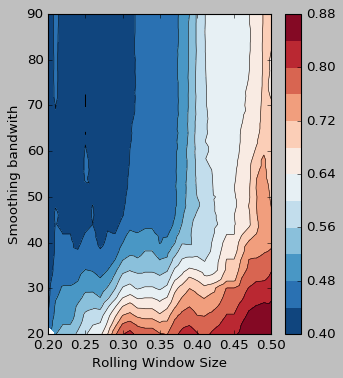

In [231]:
fig, ax = plt.subplots(figsize=(4.5,5))
#fig = plt.figure(figsize=(10,8))
plt.style.use('classic')

#z = list(storage_lag)
#z.insert(0, np.min(storage_lag))
#ax.contour(bw, rw, np.array(z).reshape(30, 38), cmap="RdBu_r")

window, bandwith = zip(*TupList)
x = window[1:]
y = bandwith[1:]
if np.max(storage_std)>np.max(storage_lag):
    z = storage_std
else:
    z= storage_lag
ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
cntr = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")
fig.colorbar(cntr, ax=ax)
ax.set(xlim=(0.2, 0.5), ylim=(20, 90))
ax.set_ylabel('Smoothing bandwith', fontsize=12)
ax.set_xlabel('Rolling Window Size', fontsize=12)

foo_fig = plt.gcf()  # 'get current figure'
# set "generateNow" in previous cell
if (generateNow):
    os.chdir(path_written_to)
    foo_fig.savefig((cityname + "-NonEssential_contour-new.png"))

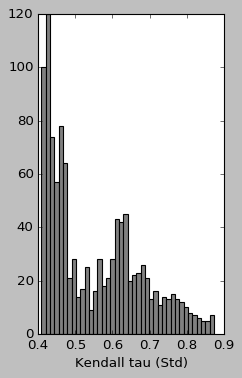

In [232]:
plt.style.use('classic')
fig = plt.figure(figsize=(3,5))

#z = list(storage_lag)
#z.insert(0, np.min(storage_lag))
#ax.contour(bw, rw, np.array(z).reshape(30, 38), cmap="RdBu_r")

if np.max(storage_std)>np.max(storage_lag):
    a = storage_std
    label = 'Std'
else:
    a= storage_lag
    label = 'AC(1)'

hist,bins = np.histogram(a,bins=40)

plt.hist(a, bins = bins, color='grey')

plt.xlabel('Kendall tau (' + label + ')')


foo_fig = plt.gcf()  # 'get current figure'
# set "generateNow" in previous cell
if (generateNow):
    os.chdir(path_written_to)
    foo_fig.savefig((cityname + "-NonEssential_histogram-new.png"))


In [340]:
help(core.ews_compute)

Help on function ews_compute in module ewstools.core:

ews_compute(raw_series, roll_window=0.4, smooth='Lowess', span=0.1, band_width=0.2, upto='Full', ews=['var', 'ac'], lag_times=[1], ham_length=40, ham_offset=0.5, pspec_roll_offset=20, w_cutoff=1, aic=['Fold', 'Hopf', 'Null'], sweep=False)
    Compute temporal and spectral EWS from time-series data.
    
    Args
    ----
    raw_series: pd.Series
        Time-series data to analyse. Indexed by time.
    roll_window: float
        Rolling window size as a proportion of the length of the time-series 
        data.
    smooth: {'Gaussian', 'Lowess', 'None'}
        Type of detrending.
    band_width: float
        Bandwidth of Gaussian kernel. Taken as a proportion of time-series length if in (0,1), 
        otherwise taken as absolute.
    span: float
        Span of time-series data used for Lowess filtering. Taken as a 
        proportion of time-series length if in (0,1), otherwise taken as 
        absolute.
    upto: int or 'Ful

In [302]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr

In [305]:
res_case_lag = [19, 5, -34, 13, -5, -1, 4, 14, -19, -1, 13, -31, 16, -10, -2, -31, -39]
res_policy_lag = [30, 26, 23, 26, 23, 12, 24, 35, 34, 18, 26, 34, 27, 24, 12, 24, 23]
essen_non_lag = [8, 15, 6, 0, 3, 3, 1, 16, 28, 1, 17, 17, 11, 19, 1, 14, 0]
essen_feb = [0.17847234 , 0.11461934, 0.12376632, 0.14967357, 0.11788663, 0.14980983, 0.18354984, 0.06544909, 
            0.13561596, 0.21196573, 0.10245689, 0.13189064, 0.09137599, 0.08521299, 0.16145117,
            0.08264314, 0.21824374]
essen_mar = [0.53115244, 0.4283166, 0.45247576, 0.45794044, 0.41889654, 0.38154285, 0.45522407, 0.30396736,
            0.47698395, 0.65598094, 0.41911805, 0.37781311, 0.3505103, 0.51222088, 0.59072493, 0.53961093, 0.52824102]
non_feb = [0.10203402 , 0.09826875, 0.06776059, 0.01997546, -0.07280331, 0.12996786, 0.11234676, 0.02562355, 
           0.06776844, 0.08485237, 0.07498395, 0.09798406, 0.08617048, 0.051147, 0.1192601, 0.09243942, 0.23685713]
non_mar = [0.66260145, 0.64397459, 0.5919121, 0.58055047, 0.62915499, 0.65745894, 0.59931912, 0.52991638, 
          0.61611624, 0.69437394, 0.57669784, 0.54182227, 0.62931645, 0.66639515, 0.70673467, 0.69600582, 0.64743469]

In [306]:
print(len(res_case_lag))
print(len(res_policy_lag))
print(len(essen_non_lag))
print(len(essen_feb))
print(len(essen_mar))
print(len(non_feb))
print(len(non_mar))

17
17
17
17
17
17
17


In [351]:
pearsonr(res_policy_lag, essen_feb)
#print('Pearsons correlation of response-policy lag and percentage change of essential Feb: %.3f' % corr_policy_change_feb)

(-0.37164828937265937, 0.14187479614471896)

In [359]:
pearsonr(res_policy_lag, essen_mar)
#print('Pearsons correlation of response-policy lag and percentage change of essential Mar: %.3f' % corr_policy_change_mar)

(-0.4545637424434859, 0.06678051731054893)

In [354]:
pearsonr(res_policy_lag, non_feb)
#print('Pearsons correlation of response-policy lag and percentage change of nonessential Feb: %.3f' % corr_policy_change_nonfeb)

(-0.24389137920062443, 0.34550326338371723)

In [360]:
pearsonr(res_policy_lag, non_mar)
#print('Pearsons correlation of response-policy lag and percentage change of nonessential Mar: %.3f' % corr_policy_change_nonmar)

(-0.6702852830988968, 0.0032356633571005607)

In [340]:
from scipy.stats import spearmanr
corr_policy_change_feb1, _ = spearmanr(res_policy_lag, essen_feb)
print('Spearman correlation of response-policy lag and percentage change of essential Feb: %.3f' % corr_policy_change_feb1)

Spearman correlation of response-policy lag and percentage change of essential Feb: -0.420


In [341]:
corr_policy_change_mar1, _ = spearmanr(res_policy_lag, essen_mar)
print('Spearman correlation of response-policy lag and percentage change of essential Mar: %.3f' % corr_policy_change_mar1)

Spearman correlation of response-policy lag and percentage change of essential Mar: -0.418


In [342]:
corr_policy_change_nonfeb1, _ = spearmanr(res_policy_lag, non_feb)
print('Spearman correlation of response-policy lag and percentage change of nonessential Feb: %.3f' % corr_policy_change_nonfeb1)

Spearman correlation of response-policy lag and percentage change of nonessential Feb: -0.304


In [343]:
corr_policy_change_nonmar1, _ = spearmanr(res_policy_lag, non_mar)
print('Spearman correlation of response-policy lag and percentage change of nonessential Mar: %.3f' % corr_policy_change_nonmar1)

Spearman correlation of response-policy lag and percentage change of nonessential Mar: -0.588


In [318]:
import seaborn as sns
import matplotlib.pyplot as plt

In [324]:
data_matrix = np.column_stack((res_case_lag, res_policy_lag, essen_non_lag, essen_feb, essen_mar, non_feb
                              , non_mar))

In [325]:
data_matrix[0]

array([19.        , 30.        ,  8.        ,  0.17847234,  0.53115244,
        0.10203402,  0.66260145])

In [375]:
df = pd.DataFrame(data_matrix, columns=['Response-case lag','Response-policy lag', 'Essential-non-essential lag', 
                                        'Essential_Feb', 'Visit Change', 'Non_Essential_Feb', 
                                        'Visit Change '])

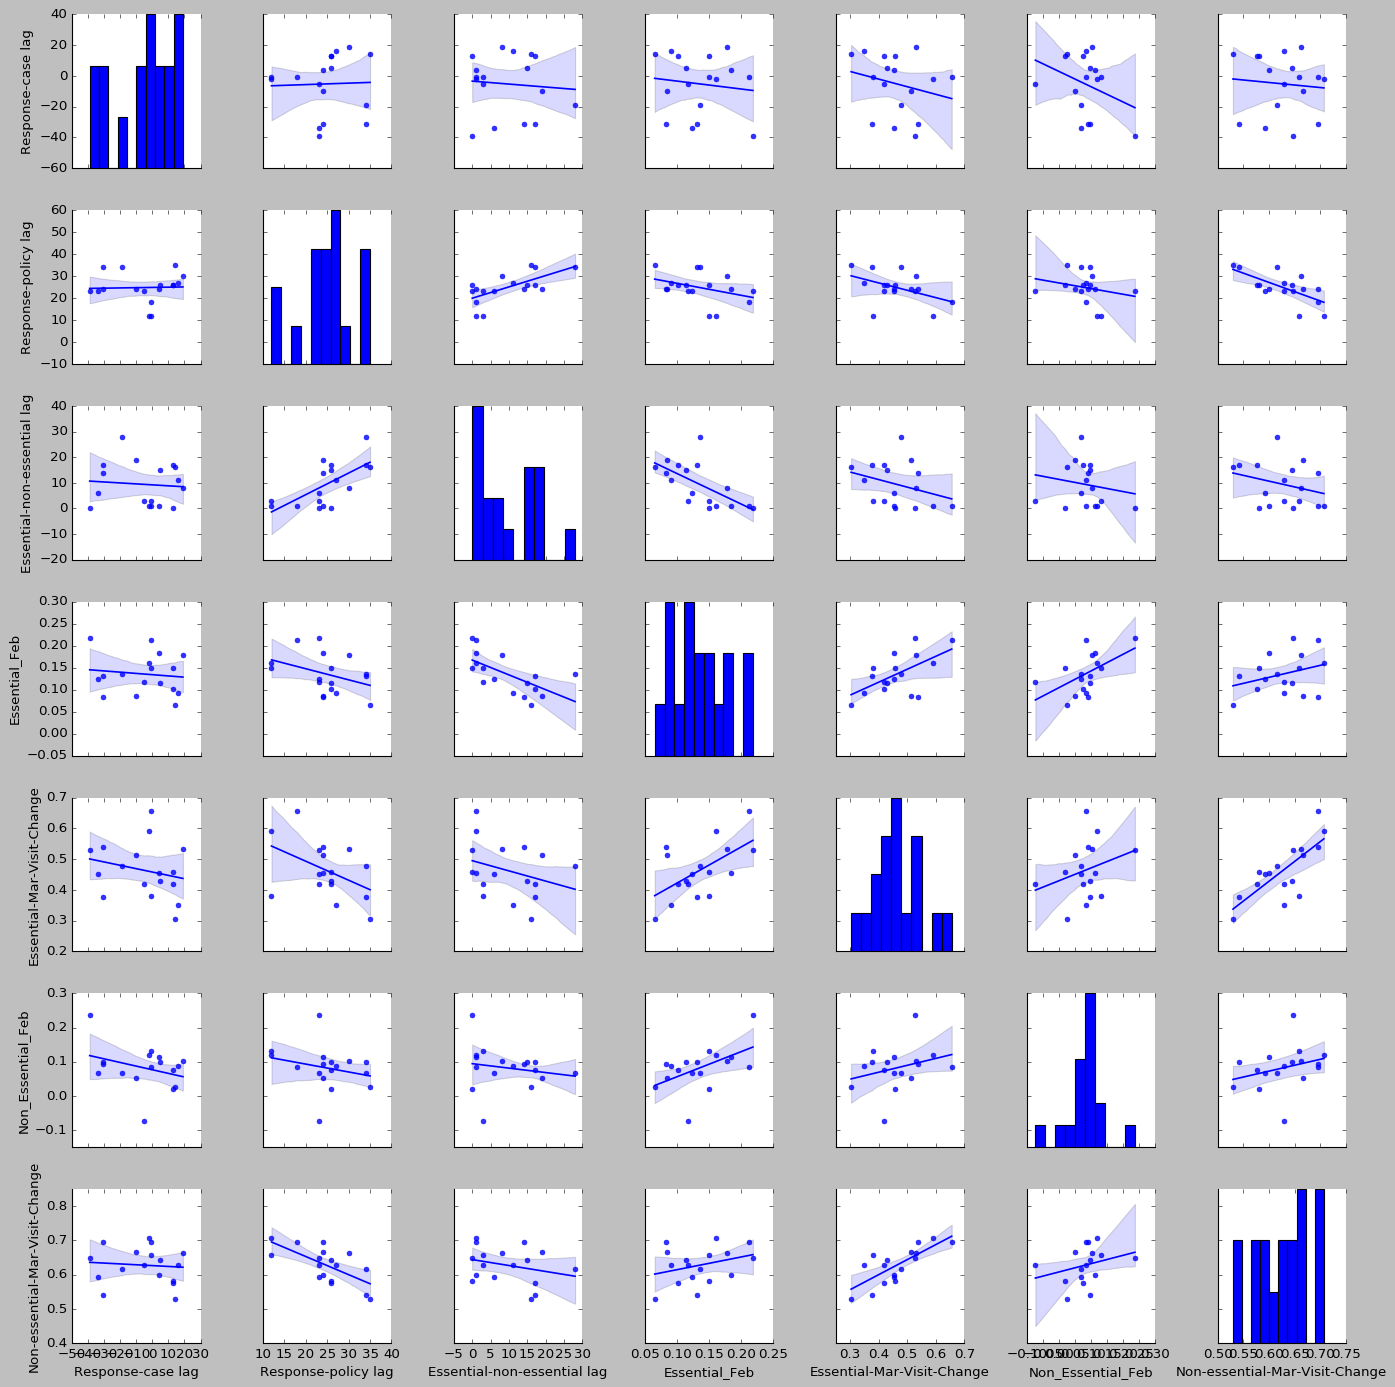

In [369]:
sns.pairplot(df, kind="reg")
plt.tight_layout()
foo_fig = plt.gcf()  # 'get current figure'
# set "generateNow" in previous cell
if (generateNow):
    os.chdir(path_written_to)
    foo_fig.savefig(('correlation_test'))
plt.show()

In [346]:
from sklearn import linear_model
import numpy as np
def GetParofPower(xdata,ydata):
    X = np.array(xdata).reshape(-1,1)
    y = np.array(ydata).reshape(-1,1)
    reg_model = linear_model.LinearRegression()
    reg_model.fit(X,y)
    # Create the fited line
    a,b = reg_model.coef_, reg_model.intercept_
    index,amp = float(a),10.0**float(b)
    return [index,amp,reg_model.score(X,y)]

In [347]:
GetParofPower(res_policy_lag, non_mar)

[-0.005308683124576845, 5.742518386986264, 0.44928236073896877]

In [348]:
GetParofPower(res_policy_lag, essen_mar)

[-0.00616974846733243, 4.133936305585163, 0.20662819594422777]

In [349]:
GetParofPower(res_policy_lag, essen_feb)

[-0.0025253998578199047, 1.5778840683336333, 0.1381224509936242]

In [350]:
GetParofPower(res_policy_lag, non_feb)

[-0.0023042582879146912, 1.37753209934484, 0.05948300484838287]

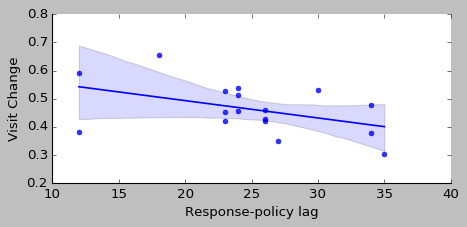

In [376]:
plt.style.use('classic')
sns.pairplot(df, x_vars=["Response-policy lag"],
             y_vars=["Visit Change"], kind="reg", height=3, aspect=2)
plt.tight_layout()
foo_fig = plt.gcf()  # 'get current figure'
# set "generateNow" in previous cell
if (generateNow):
    os.chdir(path_written_to)
    foo_fig.savefig(('correlation_test_subplot_essential_mar'))
plt.show()

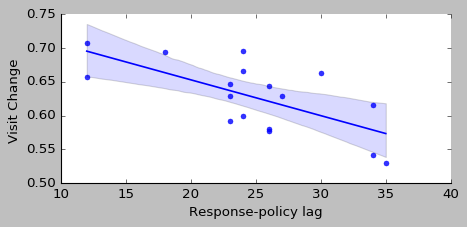

In [377]:
plt.style.use('classic')
sns.pairplot(df, x_vars=["Response-policy lag"],
             y_vars=["Visit Change "], kind="reg", height=3, aspect=2)
plt.tight_layout()
foo_fig = plt.gcf()  # 'get current figure'
# set "generateNow" in previous cell
if (generateNow):
    os.chdir(path_written_to)
    foo_fig.savefig(('correlation_test_subplot_non_essential_mar'))
plt.show()